In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    print("Computing z-score...")
    z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
def is_reco(origin):
    return origin[:3] == "rec" or origin == "flow"

In [162]:
def bin_artists(data, bin_amnt=25, separate_reco=True):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    data = data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    # Adding 'recommended' column
    if separate_reco:
        data["recommended"] = data["origin"].map(is_reco)

    return data

In [322]:
FILE_NAME = "../../data/artist_streams.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [323]:
print("Reading data...")
raw_data = pd.read_csv(FILE_NAME)
raw_data = clean_data(raw_data, z_threshold=3)
print(f"Data shape: {raw_data.shape[0]} lines, {raw_data.shape[1]} columns")

Reading data...
Computing z-score...
Cleaning...
Data shape: 1368080 lines, 8 columns


In [324]:
# Bin artists together
artist_data = bin_artists(raw_data, BIN_AMNT, SEPARATE_RECO)

print(f"Standard deviation of amount of plays per bin: {np.std(artist_data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-1367.079, 342020.75]     7679
(342020.75, 684040.5]       437
(684040.5, 1026060.25]      135
(1026060.25, 1368080.0]      44
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 584.0530797795693


In [325]:
 # Occurences of music plays in each bin
bin_distrib = artist_data.groupby("bin_nb").size()

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
artist_data["bin_nb"] = BIN_AMNT+1 - artist_data["bin_nb"]

# Normalized
bin_distrib /= bin_distrib.sum()
# Grouping users and their artist bin consumption
main_dist = artist_data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()

In [326]:
print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = artist_data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

main_dist.drop(labels=remove_idx, inplace=True)
print(f"Removed {len(remove_idx)} users.")

Removing users with fewer than 100 observations...
Removed 9 users.


In [327]:
print("Analyzing users...")
test_users = np.random.choice(main_dist.index.get_level_values("user_id").unique(), 6, replace=False)
recommended_choices = [True, False]
aggregate = pd.DataFrame(columns=["user_id", "recommended", "bin_nb", "ratio"])

Analyzing users...


## bin_distrib -- Vectorized version

In [331]:
# Vectorized computing of the users' bin ratios
user_frame = main_dist.to_frame()
user_frame.columns = ["ratio"]

# Our user_frame ends up with [user, bin_nb, ratio] 
user_plays = user_frame["ratio"].sum(level=0)
user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

user_frame = user_frame.reset_index()

In [332]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

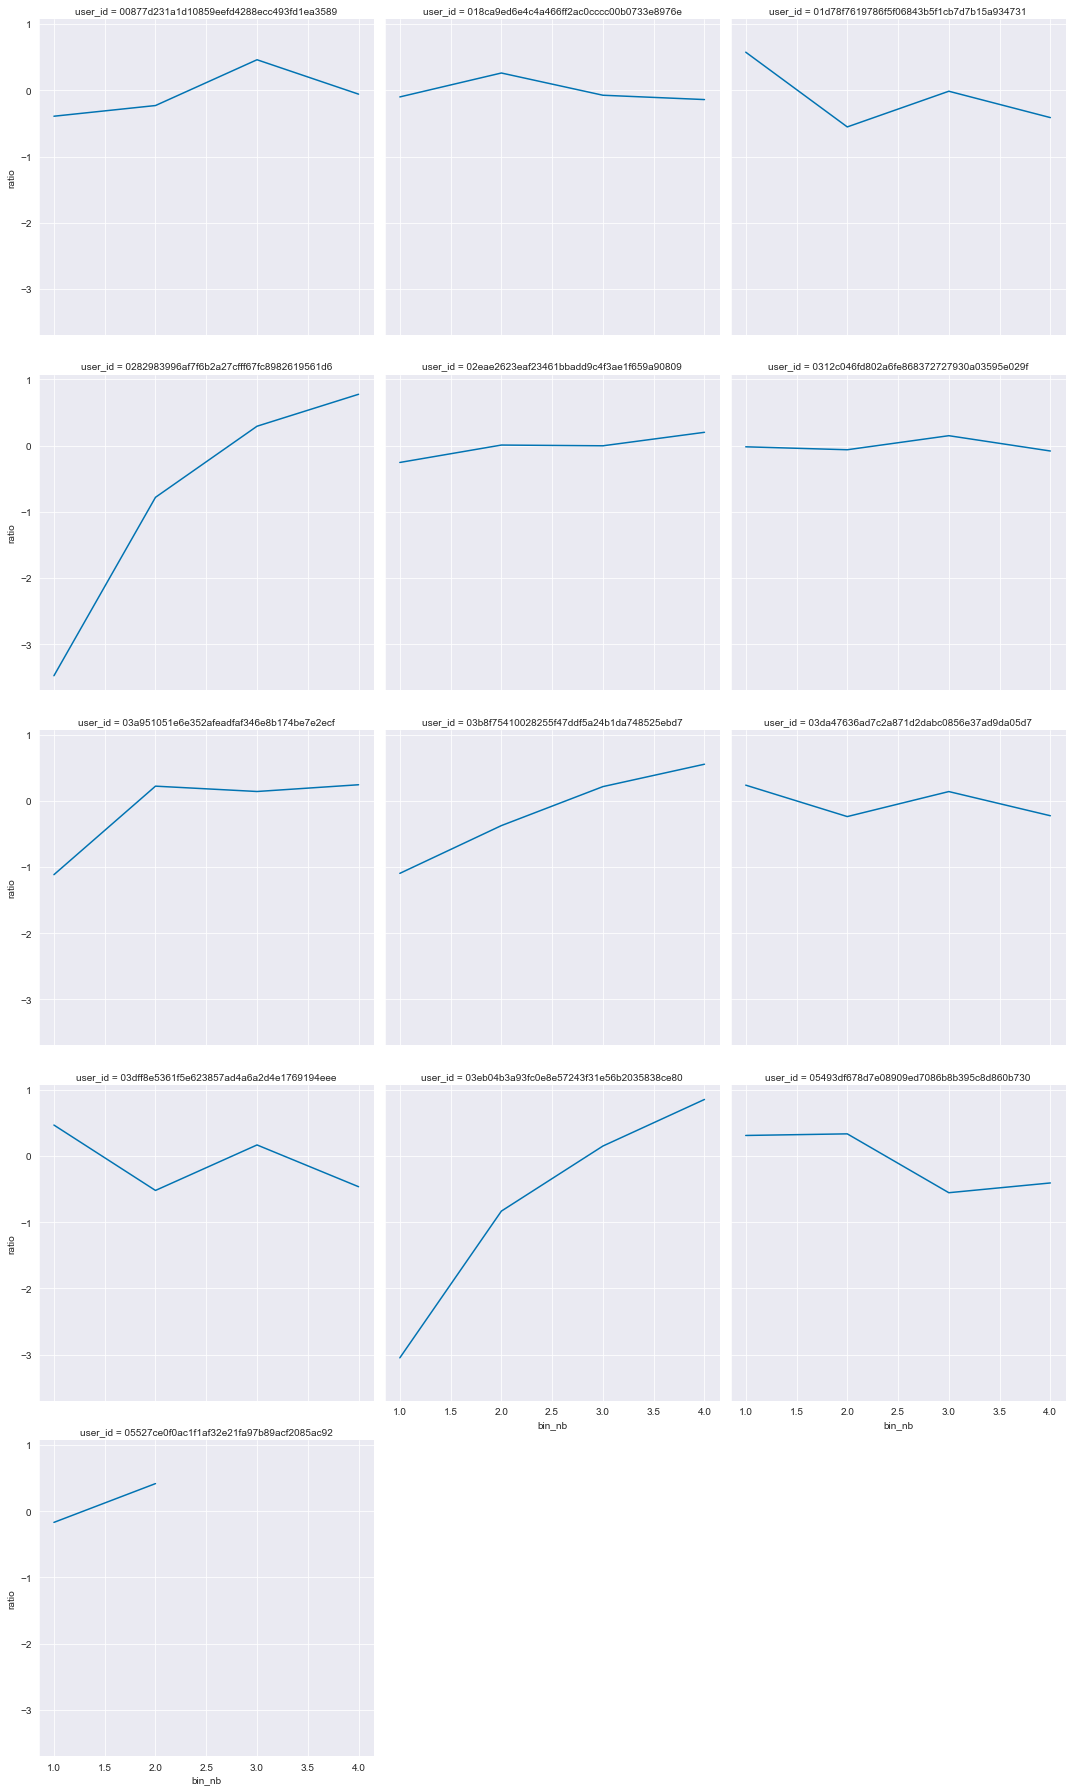

In [329]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

## bin_distrib -- Loop Version

In [179]:
# Ratio calc loop
for user, reco in itertools.product(test_users, recommended_choices):
    # In case of no separation, we pass half of the iterations, which become useless
    if SEPARATE_RECO and reco:
        pass
    try:
        # to_frame() may raise an error on account of the data being size 1 (an int64 cannot be framed)
        if SEPARATE_RECO:
            user_dist = main_dist.loc[(user, reco)].to_frame()
        else:
            user_dist = main_dist[user].to_frame()
        user_dist.columns = ["ratio"]

        # Normalizing with regards to "average" consumption
        user_dist["ratio"] /= bin_distrib * user_dist["ratio"].sum()

        # Log
        user_dist["ratio"] = np.log(user_dist["ratio"])

        # Adding data to total frame for later seaborn plotting (useless for quick-and-dirty mpl)
        user_dist = user_dist.reset_index()
        user_dist["user_id"] = user
        user_dist["recommended"] = reco
        aggregate = pd.concat([aggregate, user_dist], ignore_index=True)
    except AttributeError as e:
        warnings.warn(f"User data of size 1 ignored for user {user}, recommended {reco}")
        pass

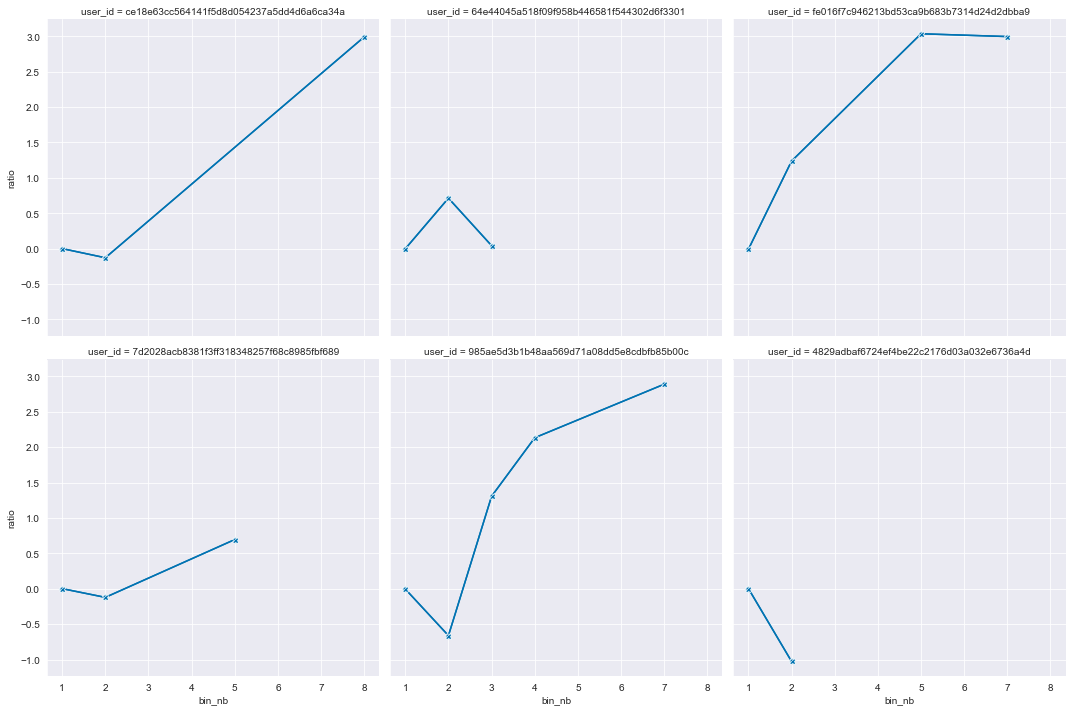

In [92]:
if not SEPARATE_RECO:
    sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
                estimator=None, data=aggregate, legend=False, style="recommended")
else:
    sns.relplot(x="bin_nb", y="ratio", hue="recommended", style="recommended", kind="line", col="user_id",
                col_wrap=3, dashes=False, markers=True, estimator=None, data=aggregate, legend="brief")
sns.despine()
plt.show()